In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler


class StandardScalerDf:
    
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, df):
        self.scaler.fit(df)
        
    def transform(self, df):
        df_ = self.scaler.transform(df)
        df_ = pd.DataFrame(df_, index=df.index, columns=df.columns)
        return df_


class LogitScalerStandardScaler:
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, df):
        df_ = np.log(df/(100 - df))
        self.scaler.fit(df_)
    
    def transform(self, df):
        df_ = np.log(df/(100 - df))
        df__ = self.scaler.transform(df_)
        df__ = pd.DataFrame(df__, index=df.index, columns=df.columns)
        return df__
    
    def inverse_transform(self, df__):
        df_ = self.scaler.inverse_transform(df__)
        df_ = pd.DataFrame(df_, index=df__.index, columns=df__.columns)
        df = 100 * np.exp(df_)/(1 + np.exp(df_))
        return df


class ZeroLogitLassoCV:
    
    def __init__(self, X_train, X_test, y_train, y_test, groups):
        self.X_train = X_train
        self.X_test = X_test
        
        self.y_train = y_train
        self.y_test = y_test
        
        self.groups = groups
        
        self.X_pp = StandardScalerDf()
        self.X_pp.fit(self.X_train)
        self.X_train_ = self.X_pp.transform(self.X_train)
        self.X_test_ = self.X_pp.transform(self.X_test)
        
        self.y_pp = LogitScalerStandardScaler()
        self.y_pp.fit(self.y_train)
        self.y_train_ = self.y_pp.transform(self.y_train)
        self.y_test_ = self.y_pp.transform(self.y_test)
        
        self.model_ = None
        
        self.y_pred_train_ = None
        self.y_pred_test_ = None
        
        self.y_pred_train = None
        self.y_pred_test = None
        
    def fit(self):
        alpha = 0.1
        
        for i in range(-2, -6, -1):
            model = Lasso(max_iter=10000)
            params = {
                "alpha":[alpha + j*10**(i) for j in range(-9, 10)]
            }
            gscv = GridSearchCV(
                model,
                params,
                cv=LeaveOneGroupOut(),
                scoring="neg_mean_squared_error",
                n_jobs=1,
                refit=True
            )
            gscv.fit(self.X_train_, self.y_train_, groups=self.groups)
            alpha = gscv.best_params_["alpha"]
            
        self.model_ = gscv.best_estimator_
    
    def predict(self):
        y_pred_train_ = self.model_.predict(self.X_train_)
        self.y_pred_train_ = pd.DataFrame(y_pred_train_, index=self.y_train_.index, columns=self.y_train_.columns)
        y_pred_test_ = self.model_.predict(self.X_test_)
        self.y_pred_test_ = pd.DataFrame(y_pred_test_, index=self.y_test_.index, columns=self.y_test_.columns)
        self.y_pred_train = self.y_pp.inverse_transform(self.y_pred_train_)
        self.y_pred_test = self.y_pp.inverse_transform(self.y_pred_test_)
        

In [2]:
from collections import defaultdict


X_path = "./X.csv"
X = pd.read_csv(X_path, index_col=["backbone", "pyridone"])
X = X.sub(X["0"], axis=0)
X = X.drop("0", axis=1)
display(X)

y_path = "./y.csv"
y = pd.read_csv(y_path, index_col=["backbone", "pyridone"])
display(y)

logo = LeaveOneGroupOut()
groups_outer = X.index.get_level_values("pyridone")
models = defaultdict(dict)

for i, (index_train, index_test) in enumerate(logo.split(X, y, groups_outer)):
    print(f"--- split={i} ---")
    columns = X.columns
    n_features = len(columns)
    
    while n_features > 4:
        print(f"--- n_features={n_features} ---")
        X_train = X.iloc[index_train][columns]
        X_test = X.iloc[index_test][columns]
        y_train = y.iloc[index_train]
        y_test = y.iloc[index_test]
        groups_inner = X_train.index.get_level_values("pyridone")
        
        model = ZeroLogitLassoCV(X_train, X_test, y_train, y_test, groups_inner)
        model.fit()
        print(model.model_.get_params()["alpha"])
        model.predict()
        models[X_test.index.get_level_values("pyridone")[0]][n_features] = model
        
        coef_df = pd.DataFrame([model.model_.coef_], index=["coef"], columns=columns)
        abs_coef_df = coef_df.abs()
        abs_coef_min = abs_coef_df.min(axis=1)[0]
        coef_df_dropped = coef_df.loc[["coef"], abs_coef_df.loc["coef"]!=abs_coef_min]
        columns = coef_df_dropped.columns
        n_features = len(coef_df_dropped.columns)


2         3         4         6         7         9  \
backbone pyridone                                                               
0        0        -0.008695 -0.057056 -0.008886 -0.026198 -0.041120  0.032579   
         1        -0.008695 -0.052599 -0.008886 -0.021780 -0.036864  0.032579   
         2        -0.008695 -0.054448 -0.008886 -0.023546 -0.038881  0.032579   
         3        -0.008695 -0.052436 -0.008886 -0.022054 -0.037311  0.032579   
         4        -0.008695 -0.053723 -0.008886 -0.025236 -0.039595  0.032579   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.008767 -0.046001 -0.008959 -0.024819 -0.038401  0.032447   
         9        -0.008767 -0.057810 -0.008959 -0.029390 -0.042452  0.032447   
         10       -0.008767 -0.046827 -0.008959 -0.026338 -0.039197  0.032447   
         11       -0.008767 -0.047412 -0.008959 -0.027697 -0.039272  0.032447   
         12       -0.008767 -0.056018 -0.008959 -0.026983 -0.040581  0.032447   

                         12        14        16        18  ...       507  \
backbone pyridone                                          ...             
0        0        -0.050338 -0.056655 -0.064589 -0.059825  ... -0.094124   
         1        -0.050736 -0.053830 -0.064255 -0.062201  ... -0.091687   
         2        -0.052990 -0.055201 -0.064532 -0.060393  ... -0.093373   
         3        -0.054012 -0.054275 -0.065711 -0.061291  ... -0.093179   
         4        -0.053024 -0.055508 -0.065862 -0.060430  ... -0.094225   
...                     ...       ...       ...       ...  ...       ...   
20       8        -0.047765 -0.056455 -0.062096 -0.060130  ... -0.091707   
         9        -0.053905 -0.055819 -0.067570 -0.058327  ... -0.094560   
         10       -0.049379 -0.056267 -0.064423 -0.059175  ... -0.091984   
         11       -0.053060 -0.056908 -0.067281 -0.056894  ... -0.092795   
         12       -0.051470 -0.054585 -0.066968 -0.060803  ... -0.092563   

                        519       538       540       543       575       597  \
backbone pyridone                                                               
0        0        -0.099624 -0.089446 -0.090086 -0.084177 -0.093292 -0.091567   
         1        -0.096809 -0.087070 -0.088095 -0.082335 -0.090797 -0.089023   
         2        -0.099589 -0.087857 -0.089579 -0.082563 -0.092372 -0.089866   
         3        -0.097998 -0.087177 -0.089471 -0.084803 -0.094709 -0.088976   
         4        -0.099139 -0.088837 -0.089840 -0.083402 -0.092848 -0.090779   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.093021 -0.084357 -0.088355 -0.081076 -0.090303 -0.081064   
         9        -0.102201 -0.088485 -0.091040 -0.083632 -0.092650 -0.085170   
         10       -0.094866 -0.084769 -0.089273 -0.082601 -0.090553 -0.081496   
         11       -0.095046 -0.083823 -0.090071 -0.081768 -0.091257 -0.081348   
         12       -0.100542 -0.087970 -0.088658 -0.082708 -0.090361 -0.084223   

                        602       605       642  
backbone pyridone                                
0        0        -0.079205 -0.087926 -0.089446  
         1        -0.075984 -0.085548 -0.087070  
         2        -0.078479 -0.086393 -0.087857  
         3        -0.078163 -0.085580 -0.087177  
         4        -0.078987 -0.087082 -0.088837  
...                     ...       ...       ...  
20       8        -0.073291 -0.083268 -0.083104  
         9        -0.079348 -0.087811 -0.088484  
         10       -0.074080 -0.083599 -0.083851  
         11       -0.074368 -0.083447 -0.083823  
         12       -0.076616 -0.086800 -0.087970  

[104 rows x 51 columns]

beta_av
backbone pyridone           
0        0         51.388357
         1         63.841924
         2         59.085161
         3         53.059721
         4         53.917807
...                      ...
20       8         19.228094
         9         24.595903
         10        21.060263
         11        19.203989
         12        23.601443

[104 rows x 1 columns]

--- split=0 ---
--- n_features=51 ---
0.014520000000000009
--- n_features=15 ---
0.0031200000000000086
--- n_features=14 ---
0.0030800000000000085
--- n_features=13 ---
1.0000000000007738e-05
--- n_features=12 ---
1.0000000000007738e-05
--- n_features=11 ---
1.0000000000007738e-05
--- n_features=10 ---
1.0000000000007738e-05
--- n_features=9 ---
1.0000000000007738e-05
--- n_features=8 ---
1.0000000000007738e-05
--- n_features=7 ---
1.0000000000007738e-05
--- n_features=6 ---
0.01185000000000001
--- n_features=5 ---
0.0010600000000000078
--- split=1 ---
--- n_features=51 ---
0.025619999999999997
--- n_features=14 ---
0.007000000000000009
--- n_features=13 ---
0.006110000000000009
--- n_features=12 ---
0.006720000000000009
--- n_features=11 ---
0.006510000000000009
--- n_features=10 ---
0.005500000000000008
--- n_features=9 ---
0.0011500000000000078
--- n_features=8 ---
0.0017200000000000086
--- n_features=7 ---
0.012710000000000008
--- n_features=6 ---
0.008450000000000008
--- n_feature

/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.286e-02, tolerance: 8.650e-03
  model = cd_fast.enet_coordinate_descent(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e-02, tolerance: 8.650e-03
  model = cd_fast.enet_coordinate_descent(
/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

/Users/takahirodoba/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e-02, tolerance: 8.650e-03
  model = cd_fast.enet_coordinate_descent(


0.00013000000000000774
--- n_features=13 ---
0.00039000000000000774
--- n_features=12 ---
1.0000000000007738e-05
--- n_features=11 ---
0.0004700000000000078
--- n_features=10 ---
1.0000000000007738e-05
--- n_features=9 ---
1.0000000000007738e-05
--- n_features=8 ---
1.0000000000007738e-05
--- n_features=7 ---
2.0000000000007737e-05
--- n_features=6 ---
0.012340000000000009
--- n_features=5 ---
0.0011000000000000079
--- split=8 ---
--- n_features=51 ---
0.015070000000000002
--- n_features=15 ---
0.002930000000000009
--- n_features=14 ---
0.0020200000000000088
--- n_features=13 ---
0.0013900000000000078
--- n_features=12 ---
1.0000000000007738e-05
--- n_features=11 ---
1.0000000000007738e-05
--- n_features=10 ---
1.0000000000007738e-05
--- n_features=9 ---
0.001050000000000008
--- n_features=8 ---
1.0000000000007738e-05
--- n_features=7 ---
0.004020000000000009
--- n_features=6 ---
0.0015800000000000078
--- n_features=5 ---
1.0000000000007738e-05
--- split=9 ---
--- n_features=51 ---
0.0

In [3]:
models_df = pd.DataFrame.from_dict(models, orient="index", columns=[i for i in range(51, 4, -1)])
display(models_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
0,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e1da580>,<__main__.ZeroLogitLassoCV object at 0x15e1c09a0>,<__main__.ZeroLogitLassoCV object at 0x15e214130>,<__main__.ZeroLogitLassoCV object at 0x15e230580>,<__main__.ZeroLogitLassoCV object at 0x15e236160>,<__main__.ZeroLogitLassoCV object at 0x15e230250>,<__main__.ZeroLogitLassoCV object at 0x15e240520>,<__main__.ZeroLogitLassoCV object at 0x15e246640>,<__main__.ZeroLogitLassoCV object at 0x15e248cd0>,<__main__.ZeroLogitLassoCV object at 0x15e25fdc0>
1,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e26db80>,<__main__.ZeroLogitLassoCV object at 0x15e27e1f0>,<__main__.ZeroLogitLassoCV object at 0x15e27c610>,<__main__.ZeroLogitLassoCV object at 0x15e28c610>,<__main__.ZeroLogitLassoCV object at 0x15e297d60>,<__main__.ZeroLogitLassoCV object at 0x15e297a00>,<__main__.ZeroLogitLassoCV object at 0x15e2a95b0>,<__main__.ZeroLogitLassoCV object at 0x15e2aa220>,<__main__.ZeroLogitLassoCV object at 0x15e2a92b0>,<__main__.ZeroLogitLassoCV object at 0x15e2baa90>
2,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,<__main__.ZeroLogitLassoCV object at 0x15e291f40>,<__main__.ZeroLogitLassoCV object at 0x15e2d1730>,<__main__.ZeroLogitLassoCV object at 0x15e2dae80>,<__main__.ZeroLogitLassoCV object at 0x15e2d90a0>,<__main__.ZeroLogitLassoCV object at 0x15e2f2ca0>
3,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e35a970>,<__main__.ZeroLogitLassoCV object at 0x15e374490>,<__main__.ZeroLogitLassoCV object at 0x15e374bb0>,<__main__.ZeroLogitLassoCV object at 0x15e3852b0>,<__main__.ZeroLogitLassoCV object at 0x15e37dc10>,<__main__.ZeroLogitLassoCV object at 0x15e391dc0>,<__main__.ZeroLogitLassoCV object at 0x15e392430>,<__main__.ZeroLogitLassoCV object at 0x15e39b3d0>,<__main__.ZeroLogitLassoCV object at 0x15e3a3c40>,<__main__.ZeroLogitLassoCV object at 0x15e3aef40>
4,<__main__.ZeroLogitLassoCV object at 0x15e3bd160>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e3e2eb0>,<__main__.ZeroLogitLassoCV object at 0x15e3e4e50>,<__main__.ZeroLogitLassoCV object at 0x15e3eeaf0>,<__main__.ZeroLogitLassoCV object at 0x15e3f2cd0>,<__main__.ZeroLogitLassoCV object at 0x15e3fb0a0>,<__main__.ZeroLogitLassoCV object at 0x15e4039a0>,<__main__.ZeroLogitLassoCV object at 0x15e40d7f0>,<__main__.ZeroLogitLassoCV object at 0x15e40f910>,<__main__.ZeroLogitLassoCV object at 0x15e425b50>,<__main__.ZeroLogitLassoCV object at 0x15e42e610>
5,<__main__.ZeroLogitLassoCV object at 0x15e42c040>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e440fd0>,<__main__.ZeroLogitLassoCV object at 0x15e438370>,<__main__.ZeroLogitLassoCV object at 0x15e364190>,<__main__.ZeroLogitLassoCV object at 0x15e24ca90>,<__main__.ZeroLogitLassoCV object at 0x15e3b8700>,<__main__.ZeroLogitLassoCV object at 0x15e3042e0>,<__main__.ZeroLogitLassoCV object at 0x15e225970>,<__main__.ZeroLogitLassoCV object at 0x15e454550>,<__main__.ZeroLogitLassoCV object at 0x15e459340>,<__main__.ZeroLogitLassoCV object at 0x15e461940>
6,<__main__.ZeroLogitLassoCV object at 0x15e46a8b0>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<__main__.ZeroLogitLassoCV object at 0x15e47b460>,<__main__.ZeroLogitLassoCV object at 0x15e47f5e0>,<__main__.ZeroLogitLassoCV object at 0x15e493220>,<__main__.ZeroLogitLassoCV object at 0x15e49ad00>,<__main__.ZeroLogitLassoCV object at 0x15e4a3d00>,<__main__.ZeroLogitLassoCV object at 0x15e4a39a0>,<__main__.ZeroLogitLassoCV object at 0x15e4ae5e0>,<__main__.ZeroLogitLassoCV object at 0x15e4b6940>,<__main__.ZeroLogitLassoCV object at 0x15e4bfb50>,<__main__.ZeroLogitLassoCV object at 0x15e4c54c0>
7,<__main__.ZeroLogitLasso

In [4]:
models_df = models_df.ffill(axis=1)
display(models_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
0,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,<__main__.ZeroLogitLassoCV object at 0x15e19c580>,...,<__main__.ZeroLogitLassoCV object at 0x15e1da580>,<__main__.ZeroLogitLassoCV object at 0x15e1c09a0>,<__main__.ZeroLogitLassoCV object at 0x15e214130>,<__main__.ZeroLogitLassoCV object at 0x15e230580>,<__main__.ZeroLogitLassoCV object at 0x15e236160>,<__main__.ZeroLogitLassoCV object at 0x15e230250>,<__main__.ZeroLogitLassoCV object at 0x15e240520>,<__main__.ZeroLogitLassoCV object at 0x15e246640>,<__main__.ZeroLogitLassoCV object at 0x15e248cd0>,<__main__.ZeroLogitLassoCV object at 0x15e25fdc0>
1,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,<__main__.ZeroLogitLassoCV object at 0x15e268eb0>,...,<__main__.ZeroLogitLassoCV object at 0x15e26db80>,<__main__.ZeroLogitLassoCV object at 0x15e27e1f0>,<__main__.ZeroLogitLassoCV object at 0x15e27c610>,<__main__.ZeroLogitLassoCV object at 0x15e28c610>,<__main__.ZeroLogitLassoCV object at 0x15e297d60>,<__main__.ZeroLogitLassoCV object at 0x15e297a00>,<__main__.ZeroLogitLassoCV object at 0x15e2a95b0>,<__main__.ZeroLogitLassoCV object at 0x15e2aa220>,<__main__.ZeroLogitLassoCV object at 0x15e2a92b0>,<__main__.ZeroLogitLassoCV object at 0x15e2baa90>
2,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,...,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e2c5a30>,<__main__.ZeroLogitLassoCV object at 0x15e291f40>,<__main__.ZeroLogitLassoCV object at 0x15e2d1730>,<__main__.ZeroLogitLassoCV object at 0x15e2dae80>,<__main__.ZeroLogitLassoCV object at 0x15e2d90a0>,<__main__.ZeroLogitLassoCV object at 0x15e2f2ca0>
3,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,<__main__.ZeroLogitLassoCV object at 0x15e2fd850>,...,<__main__.ZeroLogitLassoCV object at 0x15e35a970>,<__main__.ZeroLogitLassoCV object at 0x15e374490>,<__main__.ZeroLogitLassoCV object at 0x15e374bb0>,<__main__.ZeroLogitLassoCV object at 0x15e3852b0>,<__main__.ZeroLogitLassoCV object at 0x15e37dc10>,<__main__.ZeroLogitLassoCV object at 0x15e391dc0>,<__main__.ZeroLogitLassoCV object at 0x15e392430>,<__main__.ZeroLogitLassoCV object at 0x15e39b3d0>,<__main__.ZeroLo

In [5]:
import pickle


models_path = "./Lasso_RFE_zero_models.pickle"

with open(models_path, "wb") as f:
    pickle.dump(models_df, f)
    

In [6]:
import pickle


models_path = "./Lasso_RFE_zero_models.pickle"

with open(models_path, "rb") as f:
    models_df = pickle.load(f)
    

In [7]:
from sklearn.metrics import mean_squared_error


rmse_y_train_concat = {}
rmse_y_test_concat = {}

for column in models_df.columns:
    y_train_concat = pd.concat([model.y_train for model in models_df[column]])
    y_test_concat = pd.concat([model.y_test for model in models_df[column]])
    y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[column]])
    y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[column]])
    rmse_y_train_concat[column] = mean_squared_error(y_train_concat, y_pred_train_concat, squared=False)
    rmse_y_test_concat[column] = mean_squared_error(y_test_concat, y_pred_test_concat, squared=False)

rmse_concat_df = pd.DataFrame({"rmse_train": rmse_y_train_concat, "rmse_test": rmse_y_test_concat}).T
display(rmse_concat_df)


,51,50,49,48,47,46,45,44,43,42,...,14,13,12,11,10,9,8,7,6,5
rmse_train,4.355484,4.355484,4.355484,4.355484,4.355484,4.355484,4.355484,4.355484,4.355484,4.355484,...,4.218693,4.237185,4.254127,4.316974,4.352549,4.402149,4.479520,4.625424,5.102138,5.518737
rmse_test,7.055925,7.055925,7.055925,7.055925,7.055925,7.055925,7.055925,7.055925,7.055925,7.055925,...,6.538557,6.602291,6.798558,6.761578,6.820945,6.816451,6.569004,6.337889,6.778876,7.473343


In [18]:
import pickle


rmse_path = "./Lasso_RFE_zero_RMSE.pickle"

with open(rmse_path, "wb") as f:
    pickle.dump(rmse_concat_df, f)
    

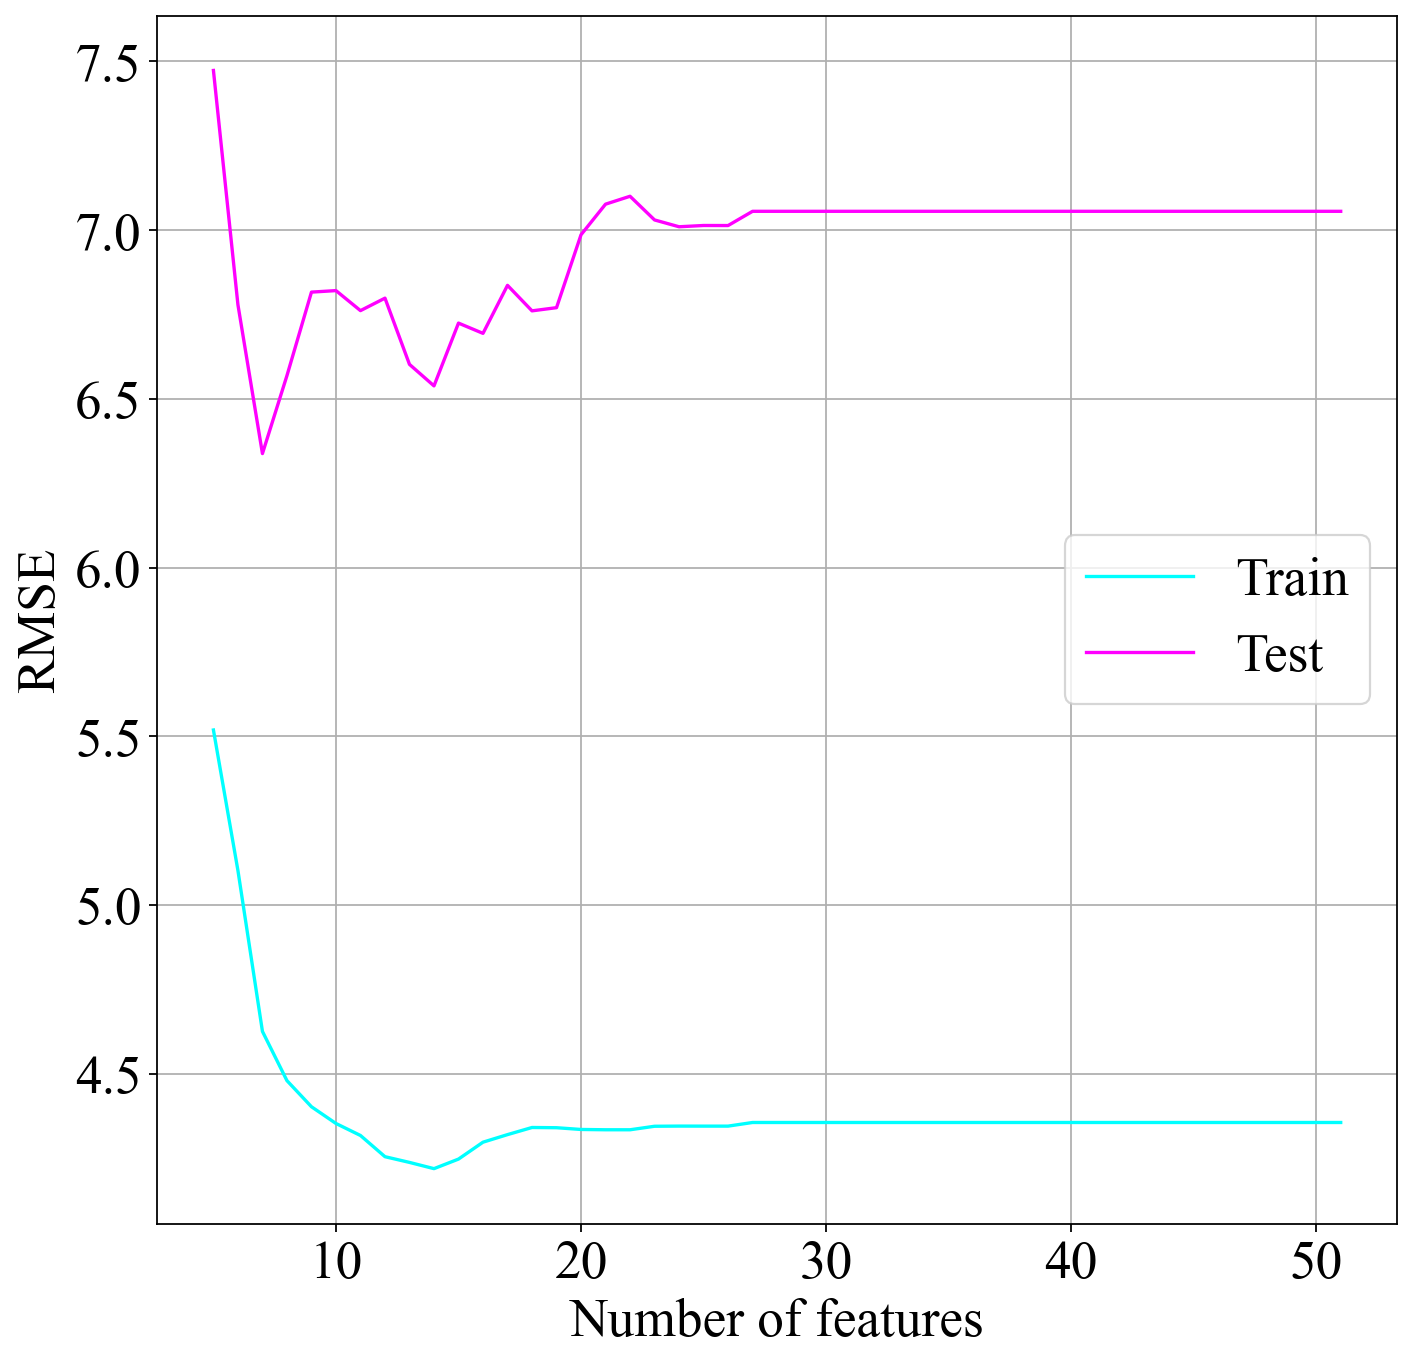

In [8]:
import matplotlib.pyplot as plt


plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Number of features")
ax.set_ylabel("RMSE")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_train"], color="cyan", label="Train")
ax.plot(rmse_concat_df.columns, rmse_concat_df.loc["rmse_test"], color="magenta", label="Test")
ax.grid()
ax.legend()
plt.savefig("./Lasso_RFE_zero_RMSE.png")
plt.show()


In [9]:
n_features_min = rmse_concat_df.loc["rmse_train"].idxmin()
print(n_features_min)

14


In [10]:
print(rmse_concat_df.at["rmse_test", n_features_min])

6.5385570094075725


In [11]:
y_train_concat = pd.concat([model.y_train for model in models_df[n_features_min]])
y_pred_train_concat = pd.concat([model.y_pred_train for model in models_df[n_features_min]])
y_test_concat = pd.concat([model.y_test for model in models_df[n_features_min]])
y_pred_test_concat = pd.concat([model.y_pred_test for model in models_df[n_features_min]])


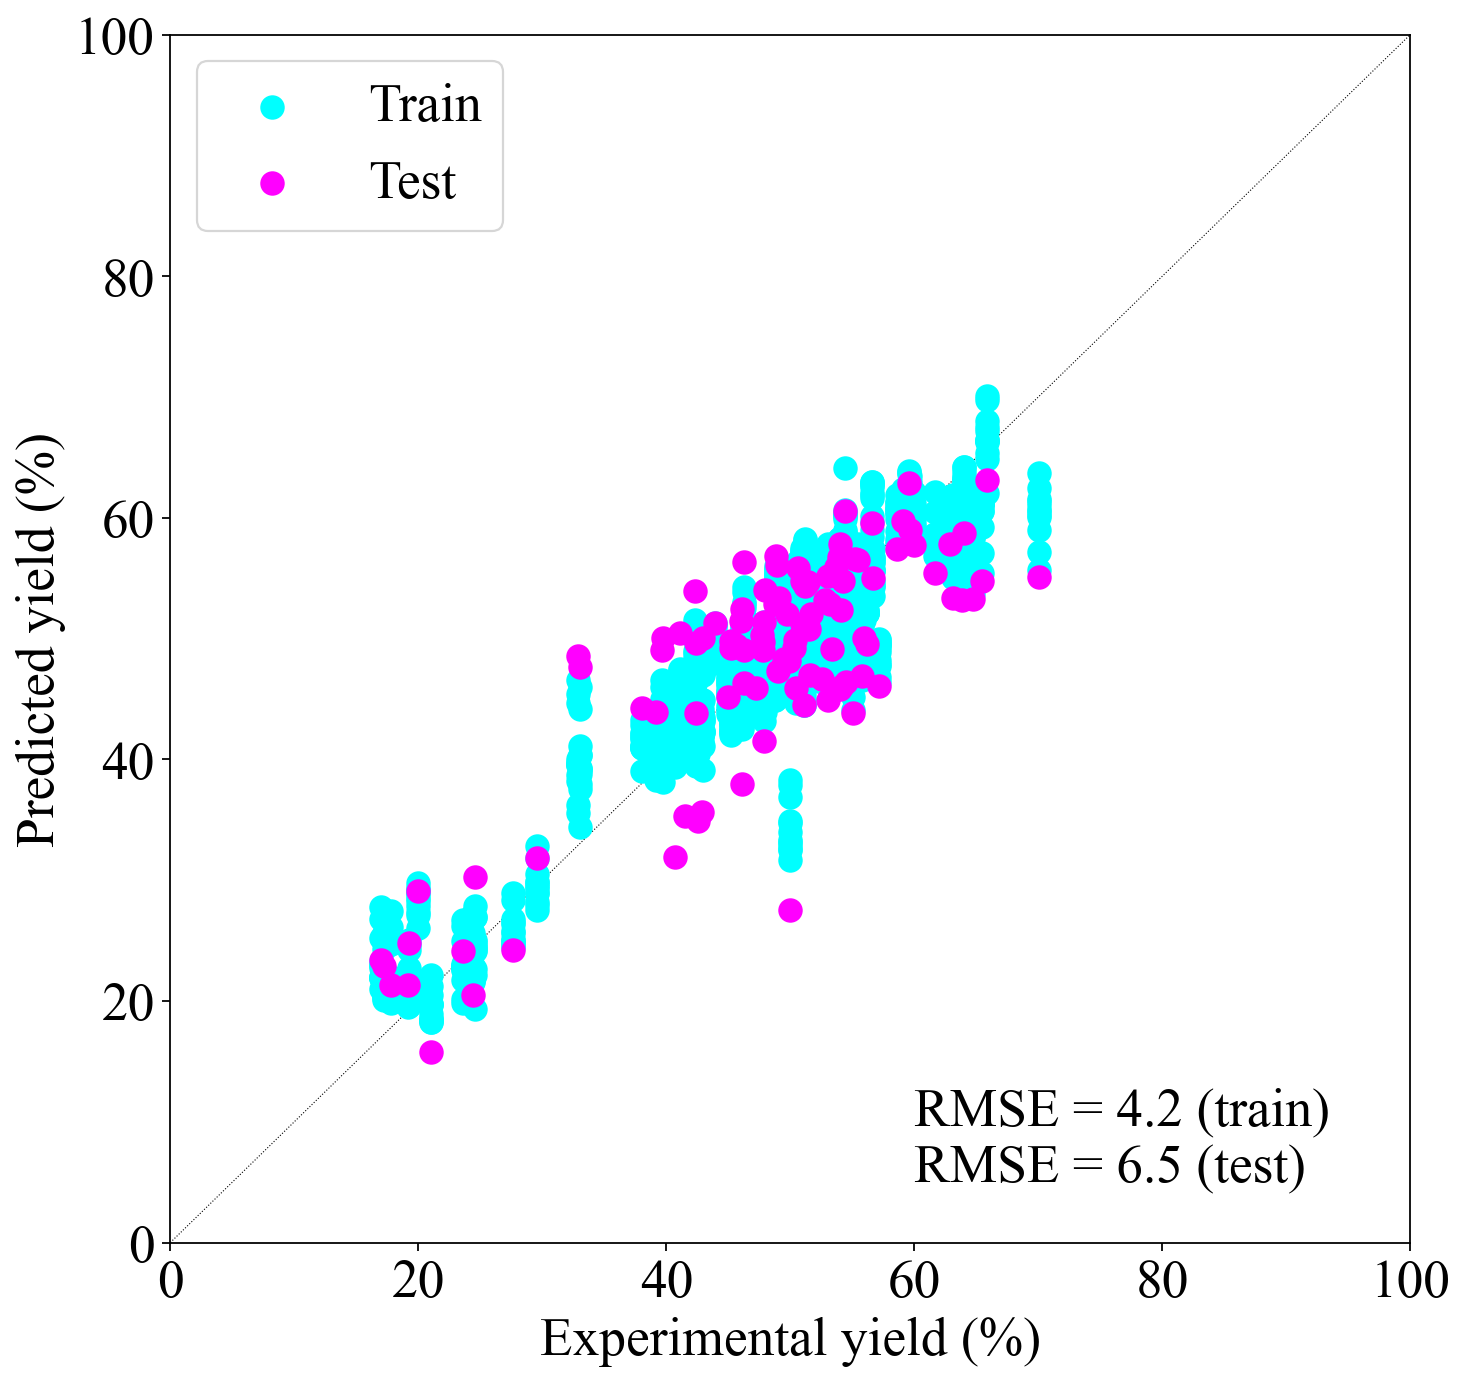

In [12]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Experimental yield (%)")
ax.set_ylabel("Predicted yield (%)")
ax.plot(
    [0, 100], [0, 100],
    color="black", linewidth=0.5, linestyle="dotted", zorder=0
)
ax.scatter(
    y_train_concat, y_pred_train_concat,
    color="cyan", s=100, label="Train", zorder=1
)
ax.scatter(
    y_test_concat, y_pred_test_concat,
    color="magenta", s=100, label="Test", zorder=2
)
ax.text(
    60, 5,
    f"RMSE = {mean_squared_error(y_train_concat, y_pred_train_concat, squared=False):1.1f} (train)\n"
    f"RMSE = {mean_squared_error(y_test_concat, y_pred_test_concat, squared=False):1.1f} (test)"
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()
plt.savefig("./Lasso_RFE_zero_scatter_all.png")
plt.show()


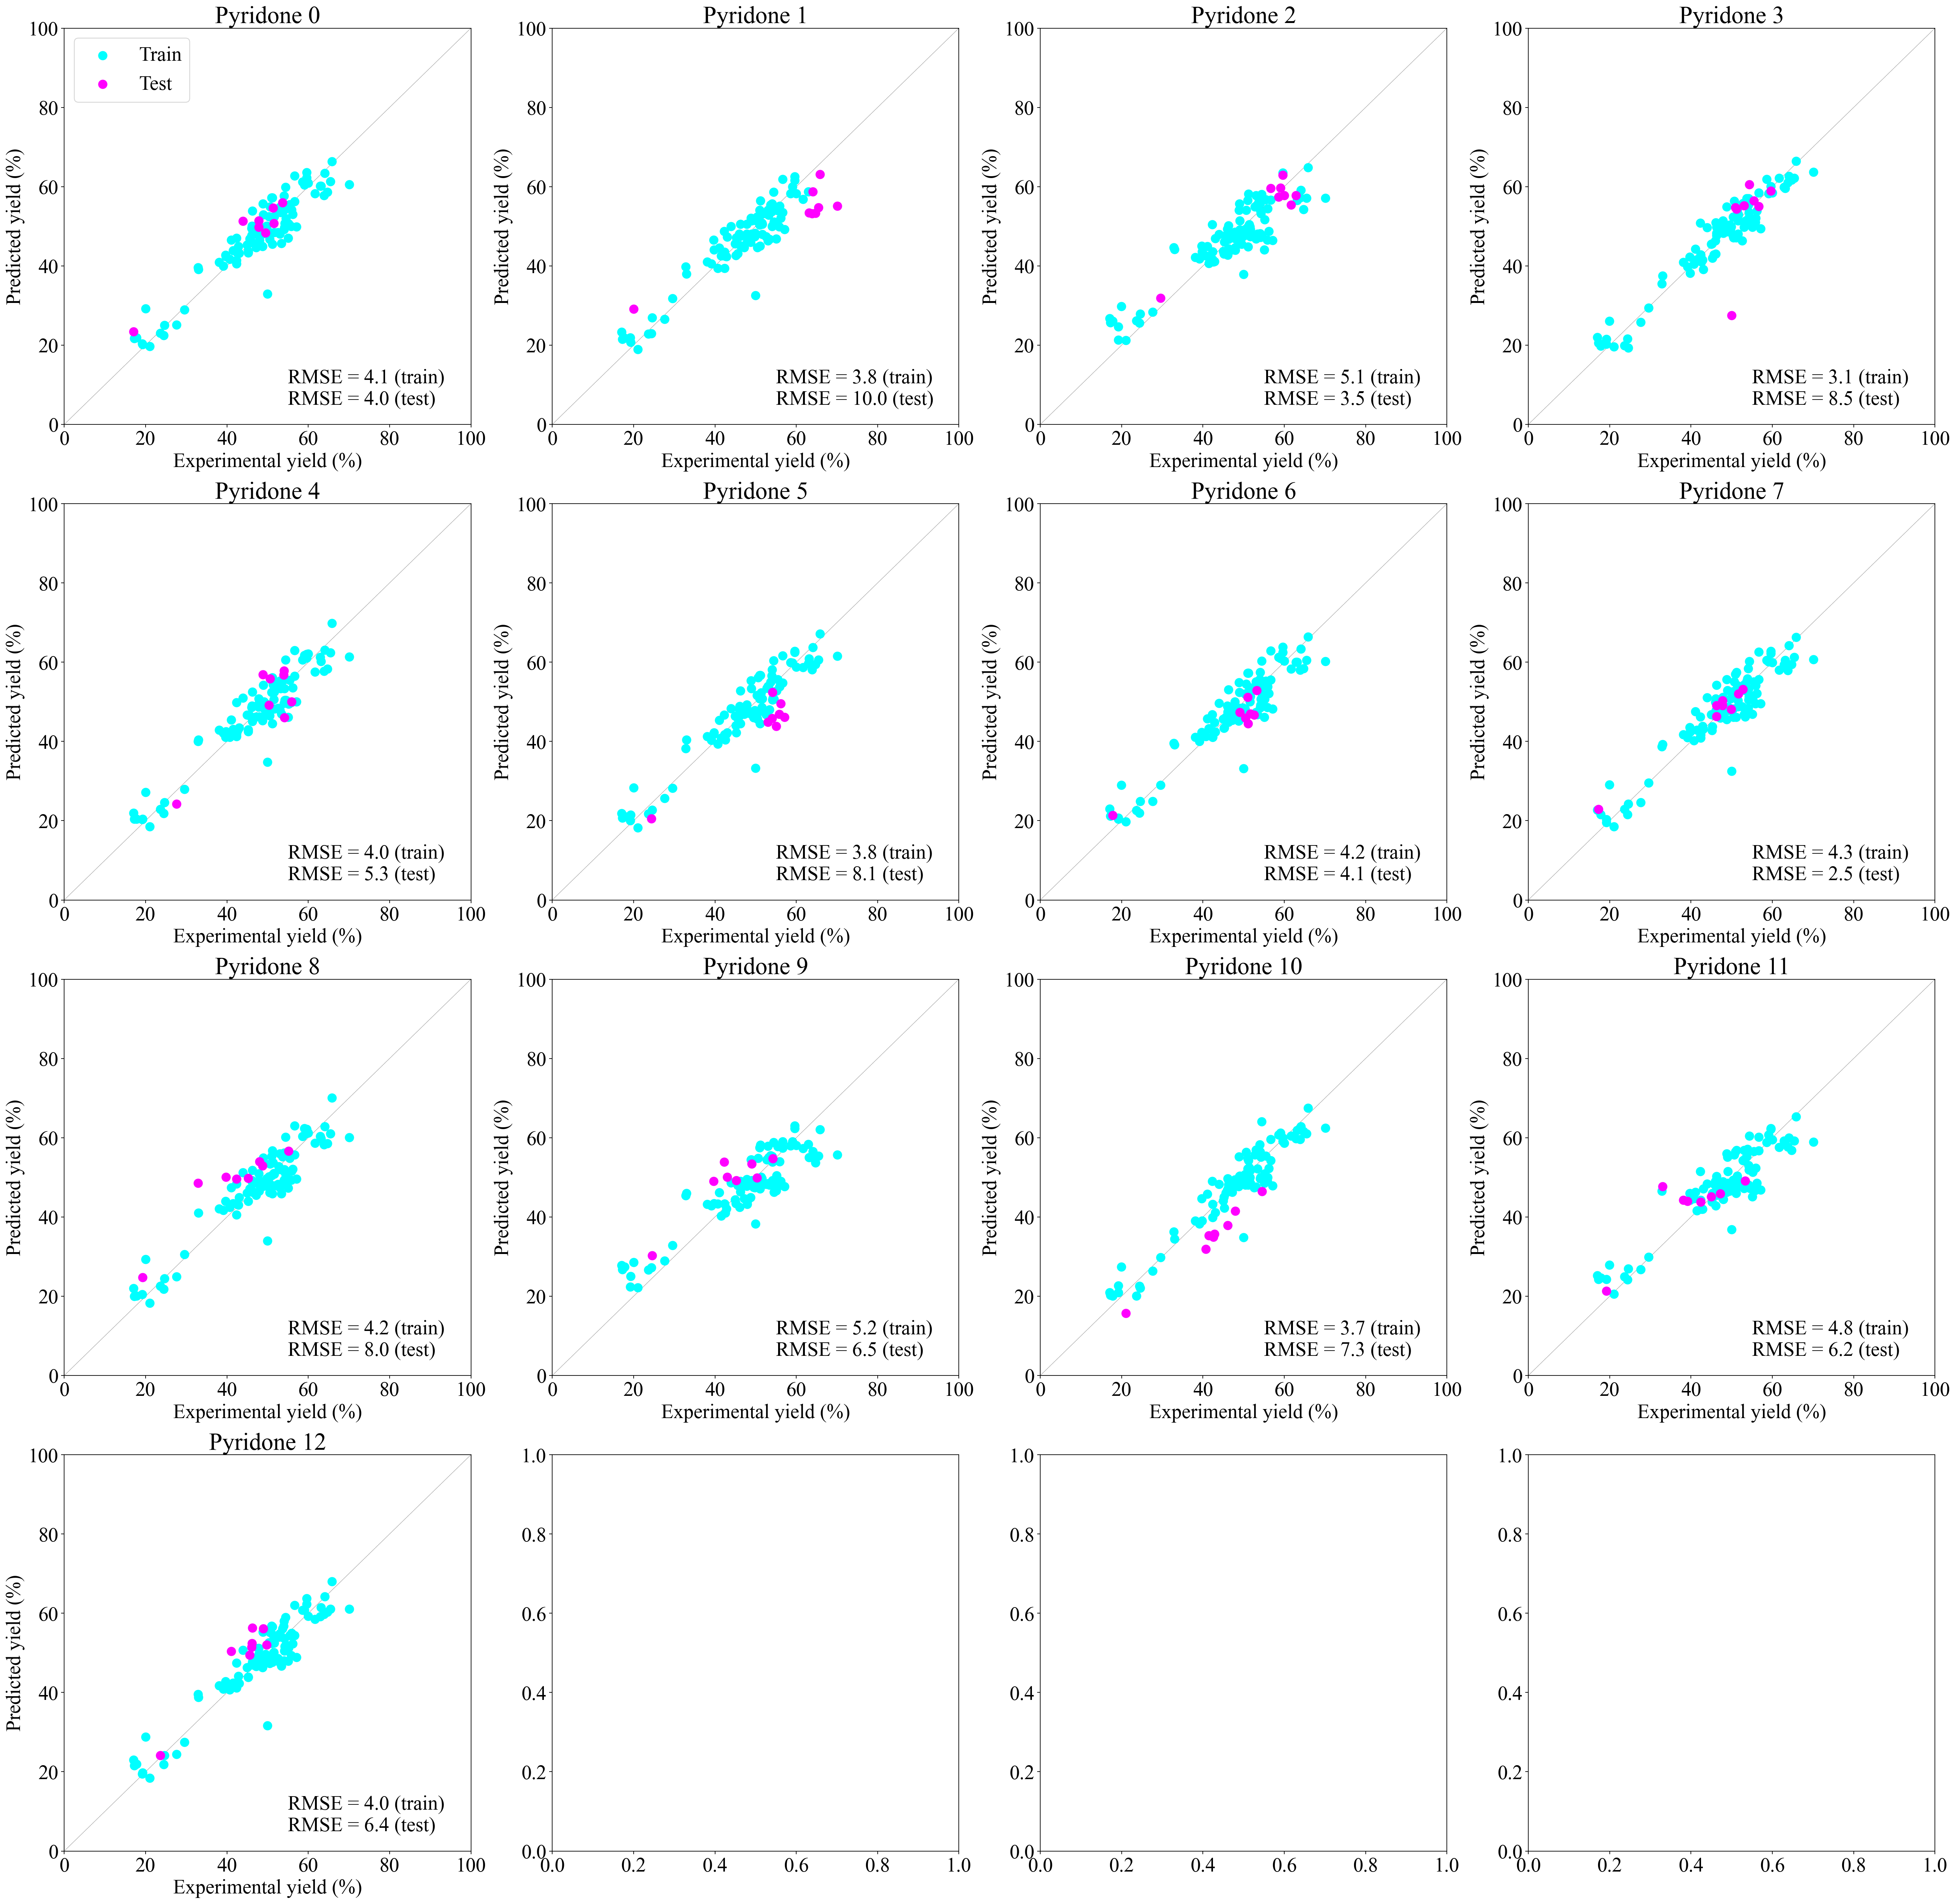

In [13]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(4, 4, figsize=(40, 40))

for i, (num, model) in enumerate(models_df[n_features_min].items()):
    div, mod = divmod(i, 4)
    axes[div, mod].set_title(f"Pyridone {num}")
    axes[div, mod].set_xlabel("Experimental yield (%)")
    axes[div, mod].set_ylabel("Predicted yield (%)")
    axes[div, mod].plot(
        [0, 100], [0, 100],
        color="black", linewidth=0.5, linestyle="dotted", zorder=0
    )
    axes[div, mod].scatter(
        model.y_train, model.y_pred_train,
        color="cyan", s=100, label="Train", zorder=1
    )
    axes[div, mod].scatter(
        model.y_test, model.y_pred_test,
        color="magenta", s=100, label="Test", zorder=2
    )
    axes[div, mod].text(
        55, 5,
        f"RMSE = {mean_squared_error(model.y_train, model.y_pred_train, squared=False):1.1f} (train)\n"
        f"RMSE = {mean_squared_error(model.y_test, model.y_pred_test, squared=False):1.1f} (test)"
    )
    axes[div, mod].set_xlim(0, 100)
    axes[div, mod].set_ylim(0, 100)
    if i == 0:
        axes[div, mod].legend()
    
plt.savefig("./Lasso_RFE_zero_scatter_each.png")
plt.show()


In [14]:
coef_dfs = []

for num, model in models_df[n_features_min].items():
    coef_df = pd.DataFrame(model.model_.coef_.reshape(1, -1), index=[num], columns=model.X_train.columns)
    coef_dfs.append(coef_df)
    
coef_dfs_concat = pd.concat(coef_dfs, axis=0, join="outer")
coef_dfs_concat = coef_dfs_concat.reindex(columns=sorted(coef_dfs_concat.columns, key=int))
coef_dfs_concat = coef_dfs_concat.fillna(0)
coef_dfs_concat.loc["mean"] = coef_dfs_concat.mean()
display(coef_dfs_concat)


,2,3,4,6,7,9,12,14,16,18,...,507,519,538,540,543,575,597,602,605,642
0,0.0,0.000000,0.0,0.000000,0.182496,-0.334530,0.159670,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.407844,0.0,-0.212214,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.069780,0.000000,-0.310700,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.344608,0.0,-0.078357,0.0,0.0,0.0
2,-0.0,0.000000,-0.0,0.339271,0.000000,-0.342308,0.036520,0.0,0.0,-0.000000,...,0.0,0.0,-0.0,0.0,0.196389,0.0,-0.410762,-0.0,-0.0,-0.0
3,0.0,-0.512008,0.0,0.000000,0.724480,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.296811,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.287472,-0.196339,0.154524,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.483020,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.000000,0.417266,-0.411044,0.000000,0.0,0.0,-0.009459,...,0.0,0.0,0.0,0.0,0.439220,0.0,-0.558487,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.000000,0.145823,-0.313514,0.130916,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.408554,0.0,-0.223139,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.000000,0.294367,-0.379675,0.128003,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.436535,0.0,-0.302049,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.000000,0.356296,-0.263846,0.106078,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.427185,0.0,-0.028668,0.0,0.0,0.0
9,-0.0,-0.000000,-0.0,0.191650,0.000000,-0.319800,0.000000,0.0,0.0,-0.000000,...,0.0,0.0,-0.0,0.0,0.131269,0.0,-0.304211,-0.0,-0.0,-0.0


In [15]:
coef_dfs_concat = coef_dfs_concat.loc[:, coef_dfs_concat.loc["mean"]!=0]
display(coef_dfs_concat)


,3,6,7,9,12,18,19,68,91,157,...,275,293,324,327,465,469,494,506,543,597
0,0.000000,0.000000,0.182496,-0.334530,0.159670,0.000000,0.000000,0.000000,-0.129446,-0.287907,...,0.000000,0.000000,0.000000,-0.154738,0.000000,-0.340245,0.202556,-0.513937,0.407844,-0.212214
1,0.000000,0.069780,0.000000,-0.310700,0.000000,0.000000,0.000000,0.000000,0.000000,-0.378322,...,0.000000,0.000000,-0.236987,-0.134922,0.000000,-0.317293,0.069862,-0.452795,0.344608,-0.078357
2,0.000000,0.339271,0.000000,-0.342308,0.036520,-0.000000,0.088502,0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.358096,0.196389,-0.410762
3,-0.512008,0.000000,0.724480,0.000000,0.000000,0.000000,0.000000,0.000000,-0.324972,-1.147505,...,0.261407,0.609027,-0.447887,0.000000,0.000000,-0.449505,0.276926,0.000000,0.296811,0.000000
4,0.000000,0.000000,0.287472,-0.196339,0.154524,0.000000,0.000000,0.000000,-0.173499,-0.130407,...,0.000000,0.000000,-0.495703,-0.112896,0.000000,-0.323358,0.274747,-0.424319,0.483020,0.000000
5,0.000000,0.000000,0.417266,-0.411044,0.000000,-0.009459,0.000000,0.186090,0.000000,-0.204790,...,0.000000,0.000000,0.000000,-0.143960,0.000000,-0.336520,0.000000,-0.306401,0.439220,-0.558487
6,0.000000,0.000000,0.145823,-0.313514,0.130916,0.000000,0.000000,0.000000,-0.122170,-0.256215,...,0.000000,0.000000,0.000000,-0.135518,0.000000,-0.273424,0.211149,-0.538239,0.408554,-0.223139
7,0.000000,0.000000,0.294367,-0.379675,0.128003,0.000000,0.000000,0.000000,0.000000,-0.310147,...,0.000000,0.000000,0.000000,-0.185752,-0.157362,-0.424428,0.102356,-0.273830,0.436535,-0.302049
8,0.000000,0.000000,0.356296,-0.263846,0.106078,0.000000,0.000000,0.012163,0.000000,-0.217955,...,0.000000,0.000000,-0.482625,-0.119026,0.000000,0.000000,0.194188,-0.566918,0.427185,-0.028668
9,-0.000000,0.191650,0.000000,-0.319800,0.000000,-0.000000,0.123930,0.000000,-0.000000,-0.000000,...,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.340536,0.131269,-0.304211


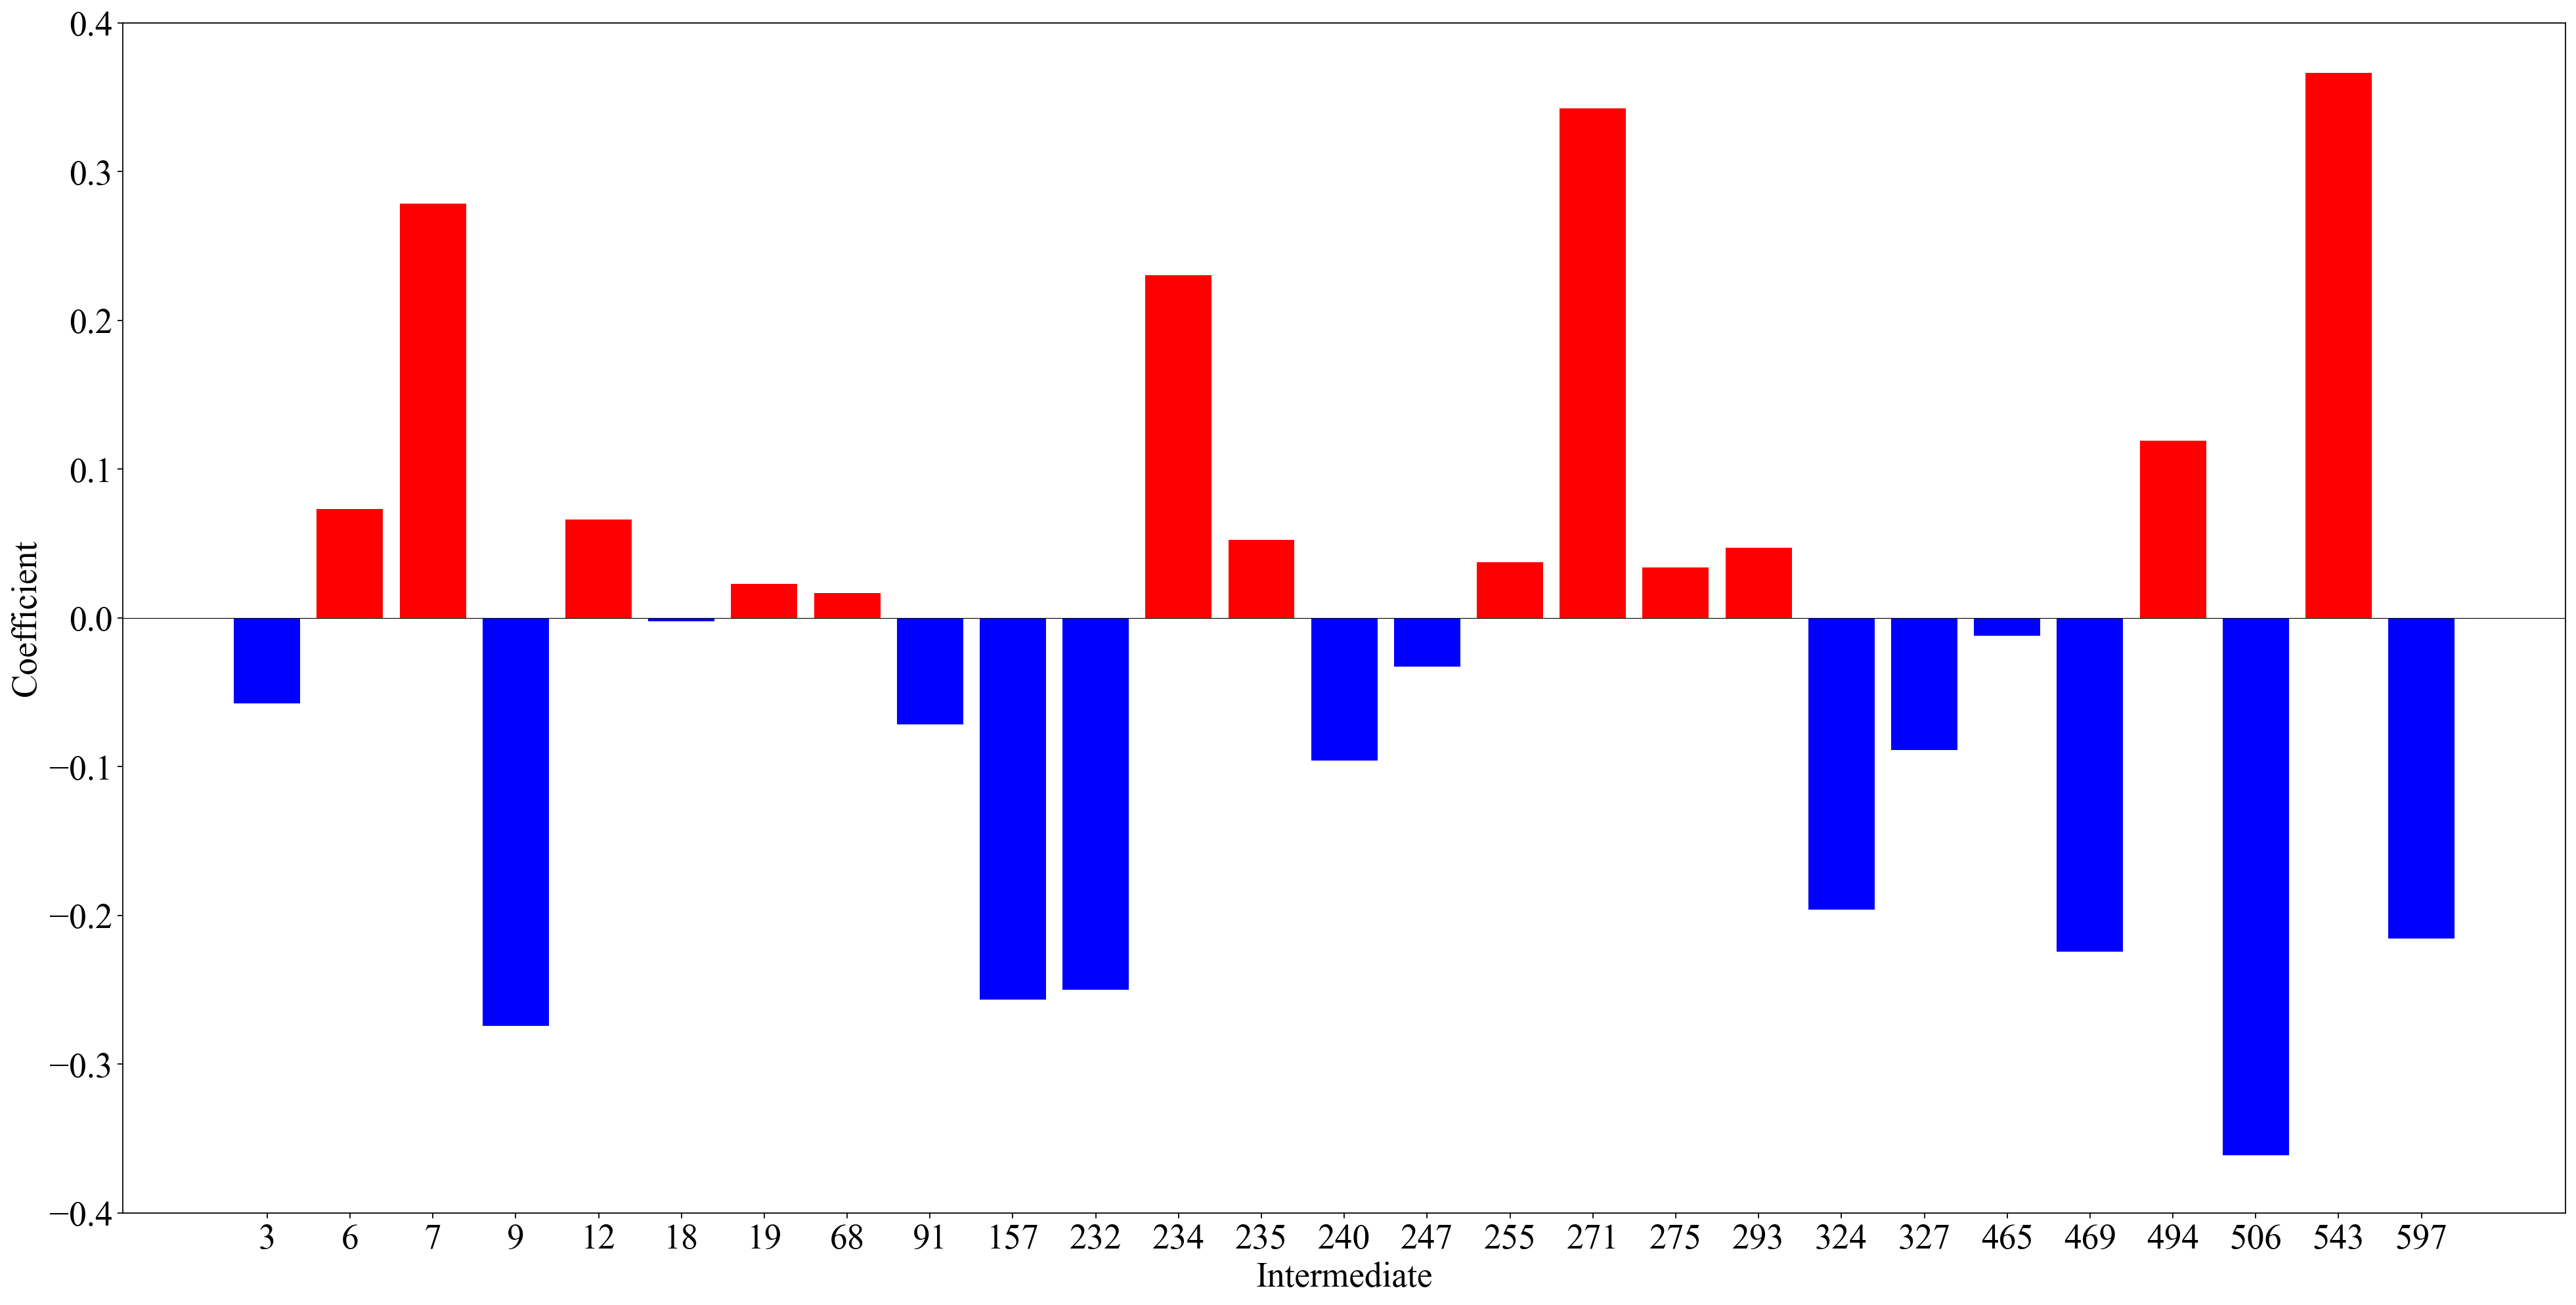

In [17]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.set_xlabel("Intermediate")
ax.set_ylabel("Coefficient")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]>0), color="red")
ax.bar(coef_dfs_concat.loc["mean"].index, coef_dfs_concat.loc["mean"]*(coef_dfs_concat.loc["mean"]<0), color="blue")
ax.axhline(y=0.0, linewidth=0.5, color="black")
ax.set_ylim(-0.4, 0.4)
plt.savefig("./Lasso_RFE_zero_coefficient.png")
plt.show()
